In [1]:
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from scipy.stats import gamma, genpareto, norm
from scipy import optimize
import scipy.stats as st
from tqdm import tqdm

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

In [3]:
def genpareto_objective_fn(theta, x, dis_func):
    scale = theta[-1]
    loc = 1 # starts from 1
    x = (np.asarray(x)-loc) / scale
    a = theta[0]
    args = (a, scale)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    return -np.sum(logpdf, axis=0)

def genpareto_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    logpdf = dis_func.logpdf(x, a, loc=0, scale=scale)
    finite_logpdf = np.isfinite(logpdf)
    # print(np.sum(finite_logpdf))
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def genpareto_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 1
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a<0:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return genpareto_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_genpareto_parameters(data, dis_func):
    function = genpareto_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [4]:
def gamma_objective_fn(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = args[0]
    scale = theta[-1]
    loc = 0 # starts from 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func)

def gamma_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a, scale=1)/scale
    total_pdf = 1 - dis_func.cdf(1, a, loc=0, scale=scale) # from 1 to inf
    pdf = pdf/total_pdf
    logpdf = np.log(pdf)
    finite_logpdf = np.isfinite(logpdf)
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def gamma_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a>1:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_gamma_parameters(data, dis_func):
    function = gamma_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args
def fit_gamma_genpareto(data, ax, x):
    a1, scale1 = fit_gamma_parameters(data, gamma)
    pdf1 = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
    score_ga = gamma_objective_fn(x=data, theta=(a1, scale1), dis_func=gamma)
    # print('Gamma: ', score_ga)
    if ax is not None:
        ax.plot(x, pdf1, color='red')
    a2, scale2 = fit_genpareto_parameters(data, genpareto)
    pdf2 = genpareto.pdf(x, a2, 1, scale2)
    score_gp = genpareto_objective_fn(x=data, theta=(a2, scale2), dis_func=genpareto)
    # print('GenPareto: ', score_gp)
    if ax is not None:
        ax.plot(x, pdf2, color='blue', label='GenPareto')
    return (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp)
def get_pdf(precip, x):
    (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
    if score_ga<score_gp:
        pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
        dis = 'Gamma'
        print(a1, scale1, dis)
    else:
        pdf = genpareto.pdf(x, a2, 1, scale2)
        dis = 'GenPareto'
        print(a2, scale2, dis)
    return pdf

In [5]:
def get_precip(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
        two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip,]
    return [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
            two_way_precip

In [7]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
two_way_precip = get_precip(sub_id=7)
sub_precip = monsoon_precip.sel(sub_id=7)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)
x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)

17.252742222601025


In [11]:
pdfs_tc = []
for sub_id in range(1, 8):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    threshold = np.quantile(sub_precip, .95)
    print(threshold)
    x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip, None, x)
    if score_ga<score_gp:
        pdfs_tc.append(pdf1)
    else:
        pdfs_tc.append(pdf2)
print(len(pdfs_tc))

21.363590636973544
7.98353434112839
7.6309751208430425


/tempest/duan0000/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)


6.2968948209451305


/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


6.469523059079158
10.647874758983226
17.252742222601025
7


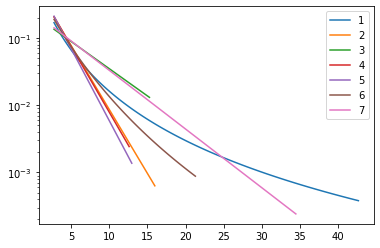

In [13]:
for sub_id in range(1, 8):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    threshold = np.quantile(sub_precip, .95)
    # print(threshold)
    x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)
    plt.plot(x, pdfs_tc[sub_id-1], label=str(sub_id))
plt.yscale('log')
plt.legend()
plt.show()

# TC

In [15]:
pdfs_tc = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tc_precip, None, x)
    if score_ga<score_gp:
        pdfs_tc.append(pdf1)
    else:
        pdfs_tc.append(pdf2)
print(len(pdfs_tc))

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


7


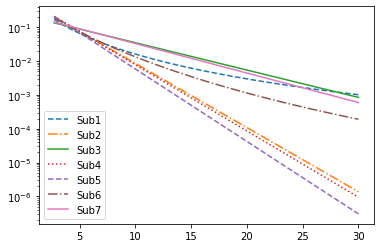

In [20]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_tc[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()

# UTT

In [21]:
pdfs_utt = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(tutt_precip, None, x)
    if score_ga<score_gp:
        pdfs_utt.append(pdf1)
    else:
        pdfs_utt.append(pdf2)
print(len(pdfs_utt))

7


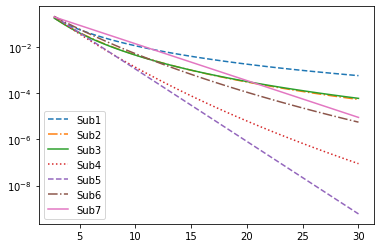

In [22]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_utt[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()

# MCS

In [23]:
pdfs_mcs = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(mcs_precip, None, x)
    if score_ga<score_gp:
        pdfs_mcs.append(pdf1)
    else:
        pdfs_mcs.append(pdf2)
print(len(pdfs_mcs))

7


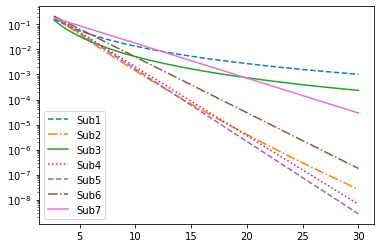

In [24]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_mcs[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()

# surge

In [25]:
pdfs_surge = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(surge_precip, None, x)
    if score_ga<score_gp:
        pdfs_surge.append(pdf1)
    else:
        pdfs_surge.append(pdf2)
print(len(pdfs_surge))

7


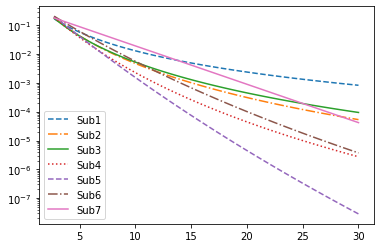

In [26]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_surge[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()

# Midtro

In [27]:
pdfs_midtro = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(midtro_precip, None, x)
    if score_ga<score_gp:
        pdfs_midtro.append(pdf1)
    else:
        pdfs_midtro.append(pdf2)
print(len(pdfs_midtro))

7


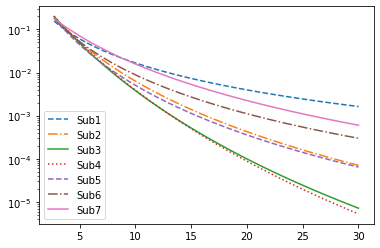

In [28]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_midtro[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()

# Front

In [29]:
pdfs_front = []
x = np.logspace(1, np.log(30), num=100, base=np.e)
for sub_id in range(1, 8):
    [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
    two_way_precip = get_precip(sub_id=sub_id)
    (a1, scale1), (a2, scale2), (pdf1, pdf2), (score_ga, score_gp) = fit_gamma_genpareto(front_precip, None, x)
    if score_ga<score_gp:
        pdfs_front.append(pdf1)
    else:
        pdfs_front.append(pdf2)
print(len(pdfs_front))

7


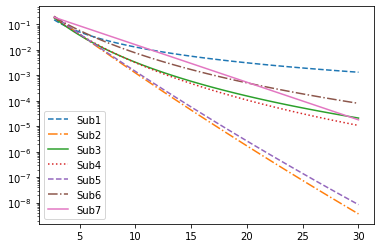

In [30]:
linestyle_str = ['dotted', 'dashed', 'dashdot', 'solid']
for sub_id in range(1, 8):
    plt.plot(x, pdfs_front[sub_id-1], label='Sub'+str(sub_id), linestyle=linestyle_str[sub_id%4])
plt.yscale('log')
plt.legend()
plt.show()